# Two-dimensional Transverse Field Ising Model

## In this example

 - Building a Hamiltonian on a square lattice
 - Eigensolving for ground states
 - Time evolution
 - Computing the dynamical structure factor

## Overview

We implement the 2D Transverse Field Ising model on the square lattice with periodic boundary conditions.  

$$H_{TFI} = -J \Big(\sum_{\langle ij \rangle} Z_i Z_j + g\sum_i X_i \Big)$$

This is one of the simplest lattice models that undergoes a quantum phase transition as the transverse field strength $g$ is tuned. At the transition, the system spontaneously breaks a global $\mathbb{Z}_2$ symmetry generated by $X_i$, resulting in ferromagnetic order along the z-axis.

We consider the $ g << 1 $ and $g >> 1$ regimes, which correspond to the ferromagnetic and paramagnetic limits of the model, respectively. In these limits, we use dynamite to find the ground state energy and lowest excited state dispersion relation, which we can compare to second-order corrections from perturbation theory (Sachdev, Quantum Phase Transitions, https://doi.org/10.1017/CBO9780511973765).

Throughout this example, we set the energy scale $J$ to 1. 

In [1]:
import numpy as np
import matplotlib.pyplot as plt

from dynamite.operators import sigmax, sigmay, sigmaz, op_sum
from dynamite import config

## 1. $g << 1$

At $g = 0$, the symmetry-broken ground state is ordered along the z-axis: all the spins either point up or down. By turning on a small perturbation $g$, fluctuations are induced along the x-axis.

In [2]:
Lx = 4
Ly = 4

N = Lx*Ly

g = 2
 
# mapping from lattice indices to {0, 1, ..., Lx*Ly}
idx = {i: {j: Ly*i + j for j in range(Ly)} for i in range(Lx)}

# horizontal interactions
ZZ_h = op_sum(sigmaz(idx[i][j])*sigmaz(idx[(i+1)%Lx][j]) for i in range(Lx) \
                                                        for j in range(Ly))
# vertical interactions
ZZ_v = op_sum(sigmaz(idx[i][j])*sigmaz(idx[i][(j+1)%Ly]) for i in range(Lx) \
                                                        for j in range(Ly))

# onsite X term
X = op_sum(sigmax(idx[i][j]) for i in range(Lx) for j in range(Ly))

TFI = -(ZZ_h + ZZ_v - g*X)

We compare the exact ground state energy to the perturbation theory result at order $g^2$:

$E_0 = -N(2 + g^2/8 + O(g^4))$

In [3]:
e_gs, gs = TFI.eigsolve(getvecs=True)

In [4]:
print('Exact ground state: ', e_gs[0])
print('Second order perturbation theory: ', -N*(2 + g**2/8))

Exact ground state:  -40.19019443767046
Second order perturbation theory:  -40.0


Well, it's always a good day when perturbation theory is working as expected. 

Next, we compute the dynamical structure factor: we flip a spin on site $(0, 0)$ of the lattice and measure $Y_{i, j}(t)$. After Fourier transforming both the spatial and time domains, we compare the structure factor $S(\vec k, \omega)$ to the dispersion relation:

$\epsilon_{\vec k} = 8 - \frac{g^2}{4}(1 + \cos(k_x a) + \cos(k_y a)) + O(g^3)$

For this example, we follow Lin et al, arXiv:2112.08394, and Steven Thomson's blog post: https://steventhomson.co.uk/post/quench_spectroscopy/

In [5]:
flip = 1/np.sqrt(2)*(sigmaz(idx[0][0]) + sigmax(idx[0][0]))
flip.subspace = gs[0].subspace

psi = flip*gs[0]

In [6]:
num_ts = 101
ts = np.linspace(0, 10, num_ts)
dt = ts[1] - ts[0]

meas = np.zeros([num_ts, Lx, Ly])

for t_idx, t in enumerate(ts):
    
    psi = TFI.evolve(psi, dt)
    
    for i in range(Lx):
        for j in range(Ly):
            yy = sigmay(idx[i][j])
            yy.subspace = psi.subspace
            meas[t_idx, i, j] = np.real(psi.dot(yy*psi))

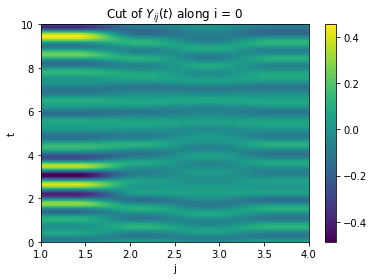

In [7]:
plt.imshow(meas[:, 0, :], aspect='auto', extent=(1, Ly, ts[0], ts[-1]))

plt.xlabel('j')
plt.ylabel('t')
plt.title('Cut of $Y_{ij}(t)$ along i = 0')
plt.colorbar()

In [8]:
dsf = np.fft.fftn(meas)
dsf = dsf/np.max(dsf)
dsf = np.fft.fftshift(dsf)

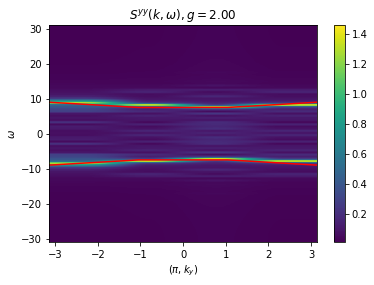

In [9]:
energies = np.fft.fftfreq(num_ts)*2*np.pi/dt

spectrum = np.zeros(Ly)

kx_range = np.linspace(-np.pi, np.pi, Lx)
ky_range = np.linspace(-np.pi, np.pi, Ly)

kx_idx = 0
for i in range(Ly):
    spectrum[i] = 8 - g**2/4*(1 + np.cos(kx_range[kx_idx]) + np.cos(ky_range[i]))

plt.imshow(np.abs(dsf[:, kx_idx, :]), aspect='auto', 
           extent = (-np.pi, np.pi, min(energies), max(energies)))

plt.plot(ky_range, spectrum,'r-')
plt.plot(ky_range, -spectrum,'r-')

plt.ylabel(r'$\omega$')
plt.xlabel(r'$(\pi, k_y)$')

plt.title('$S^{yy}(k, \omega), g= %.2f$'%(g))
plt.colorbar()

# 2. $g >> 1$

At $g = \infty$, the ground state is disordered, and all spins point along the x-axis. At large, but finite, $g$, fluctuations are induced along the z-axis.

In [10]:
Lx = 4
Ly = 4

N = Lx*Ly

g = 4
 
# mapping from lattice indices to {0, 1, ..., Lx*Ly}
idx = {i: {j: Ly*i + j for j in range(Ly)} for i in range(Lx)}

# horizontal interactions
ZZ_h = op_sum(sigmaz(idx[i][j])*sigmaz(idx[(i+1)%Lx][j]) for i in range(Lx) \
                                                        for j in range(Ly))
# vertical interactions
ZZ_v = op_sum(sigmaz(idx[i][j])*sigmaz(idx[i][(j+1)%Ly]) for i in range(Lx) \
                                                        for j in range(Ly))

# onsite X term
X = op_sum(sigmax(idx[i][j]) for i in range(Lx) for j in range(Ly))

TFI = -(ZZ_h + ZZ_v - g*X)

We compare the exact ground state energy to the perturbation theory result at order $\frac{1}{g^2}$:

$E_0 = -Ng(1 + \frac{1}{2g^2} + O(\frac{1}{g^3}))$

In [11]:
e_gs, gs = TFI.eigsolve(getvecs=True)

In [12]:
print('Exact ground state: ', e_gs[0])
print('Second order perturbation theory: ', -N*g*(1 + 1/(2*g**2)))

Exact ground state:  -66.22361988353998
Second order perturbation theory:  -66.0


Next, we compute the dynamical structure factor: we flip a spin on site $(0, 0)$ of the lattice and measure $Y_{i, j}(t)$. After Fourier transforming both the spatial and time domains, we compare the structure factor $S(\vec k, \omega)$ to the dispersion relation:

$\epsilon_{\vec k} = g(2 - \frac{2}{g}(\cos(k_xa) + \cos(k_ya)) + \frac{1}{2g^2}(1 - \cos(2k_xa) - \cos(2k_ya)) + O(\frac{1}{g^3}))$

In [13]:
flip = 1/np.sqrt(2)*(sigmaz(idx[0][0]) + sigmax(idx[0][0]))
flip.subspace = gs[0].subspace

psi = flip*gs[0]

In [14]:
num_ts = 101
ts = np.linspace(0, 10, num_ts)
dt = ts[1] - ts[0]

meas = np.zeros([num_ts, Lx, Ly])

for t_idx, t in enumerate(ts):
    
    psi = TFI.evolve(psi, dt)
    
    for i in range(Lx):
        for j in range(Ly):
            yy = sigmay(idx[i][j])
            yy.subspace = psi.subspace
            meas[t_idx, i, j] = np.real(psi.dot(yy*psi))

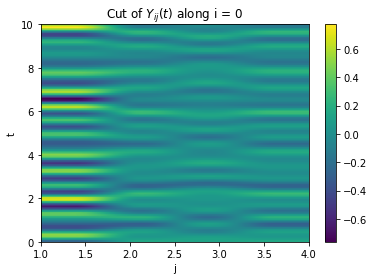

In [15]:
plt.imshow(meas[:, 0, :], aspect='auto', extent=(1, Ly, ts[0], ts[-1]))

plt.xlabel('j')
plt.ylabel('t')
plt.title('Cut of $Y_{ij}(t)$ along i = 0')
plt.colorbar()

In [16]:
dsf = np.fft.fftn(meas)
dsf = dsf/np.max(dsf)
dsf = np.fft.fftshift(dsf)

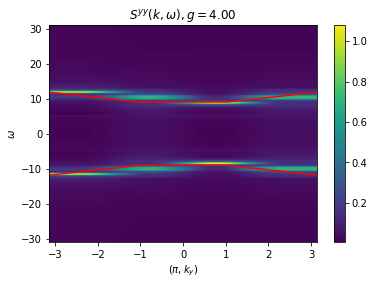

In [17]:
energies = np.fft.fftfreq(num_ts)*2*np.pi/dt

spectrum = np.zeros(Ly)

kx_range = np.linspace(-np.pi, np.pi, Lx)
ky_range = np.linspace(-np.pi, np.pi, Ly)

kx_idx = 0
for i in range(Ly):
    spectrum[i] = g*(2 - 2/g*(np.cos(kx_range[kx_idx]) + np.cos(ky_range[i])) + \
                         1/(2*g**2)*(1 - np.cos(2*kx_range[kx_idx]) - np.cos(2*ky_range[i])))

plt.imshow(np.abs(dsf[:, kx_idx, :]), aspect='auto', 
           extent = (-np.pi, np.pi, min(energies), max(energies)))

plt.plot(ky_range, spectrum,'r-')
plt.plot(ky_range, -spectrum,'r-')

plt.ylabel(r'$\omega$')
plt.xlabel(r'$(\pi, k_y)$')

plt.title('$S^{yy}(k, \omega), g= %.2f$'%(g))

plt.colorbar()